### Fundamentals of Natural Language Processing
# Negation and Uncertainty Detection using a Deep Learning Based Approach

*Authors:*

> *Anna Blanco, Agustina Lazzati, Stanislav Bultaskii, Queralt Salvadó*

*Aims:*
> The goal of this approach is to train a single Bidirectional Long Short-Term Memory (BiLSTM) neural network using word embeddings generated by FastText. The model will be designed to perform joint detection of negation and uncertainty cues, as well as scope detection, within a unified architecture.



In [1]:
# Import necessary libraries and functions
import json
import spacy
from collections import defaultdict
import re
import pandas as pd
import numpy as np
import pickle

In [2]:
with open("lstm_data.pkl", "rb") as f:
    data_dict = pickle.load(f)

lstm_train_data_neg_cue = data_dict["lstm_train_data_neg_cue"]
lstm_train_data_neg_scope = data_dict["lstm_train_data_neg_scope"]
lstm_train_data_unc_cue = data_dict["lstm_train_data_unc_cue"]
lstm_train_data_unc_scope = data_dict["lstm_train_data_unc_scope"]

lstm_test_data_neg_cue = data_dict["lstm_test_data_neg_cue"]
lstm_test_data_neg_scope = data_dict["lstm_test_data_neg_scope"]
lstm_test_data_unc_cue = data_dict["lstm_test_data_unc_cue"]
lstm_test_data_unc_scope = data_dict["lstm_test_data_unc_scope"]

print(lstm_train_data_unc_cue[10])
print(lstm_train_data_unc_scope[10])

(['la', 'uretrografia', 'miccional', 'muestra', 'una', 'uretra', 'prostatica', 'dilatada', ',', 'sin', 'claras', 'estenosis', 'focales', 'confirmandose', 'la', 'existencia', 'de', 'las', 'dos', 'estenosis', 'de', 'uretra', 'anterior', 'descritas', 'previamente', '.'], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
(['la', 'uretrografia', 'miccional', 'muestra', 'una', 'uretra', 'prostatica', 'dilatada', ',', 'sin', 'claras', 'estenosis', 'focales', 'confirmandose', 'la', 'existencia', 'de', 'las', 'dos', 'estenosis', 'de', 'uretra', 'anterior', 'descritas', 'previamente', '.'], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


In [3]:
def merge_all_labels(
    neg_cues, neg_scopes,
    unc_cues, unc_scopes,
    neg_cue_prefix="NEG", neg_scope_prefix="NSCO",
    unc_cue_prefix="UNC", unc_scope_prefix="UNSCO"
):
    merged = []
    for nc, ns, uc, us in zip(neg_cues, neg_scopes, unc_cues, unc_scopes):
        labels = []
        if nc != 0:
            labels.append(f"{neg_cue_prefix}_{nc}")
        if ns != 0:
            labels.append(f"{neg_scope_prefix}_{ns}")
        if uc != 0:
            labels.append(f"{unc_cue_prefix}_{uc}")
        if us != 0:
            labels.append(f"{unc_scope_prefix}_{us}")

        merged_label = "+".join(labels) if labels else "0"

        # Handle unwanted combinations
        if merged_label == "NEG_1+NSCO_1":
            merged_label = "NEG_1"
        elif merged_label in {
            "NEG_1+UNSCO_1",
            "NSCO_1+UNSCO_1",
            "UNC_1+UNSCO_1"
        }:
            merged_label = "0"

        merged.append(merged_label)
    return merged

In [4]:
# Merge all data: negation + uncertainty
lstm_train_data_all = [
    (tokens, merge_all_labels(neg_cue_labels, neg_scope_labels, unc_cue_labels, unc_scope_labels))
    for ((tokens, neg_cue_labels), (_, neg_scope_labels),
          (_, unc_cue_labels), (_, unc_scope_labels)) in zip(
        lstm_train_data_neg_cue,
        lstm_train_data_neg_scope,
        lstm_train_data_unc_cue,
        lstm_train_data_unc_scope
    )
]

lstm_test_data_all = [
    (tokens, merge_all_labels(neg_cue_labels, neg_scope_labels, unc_cue_labels, unc_scope_labels))
    for ((tokens, neg_cue_labels), (_, neg_scope_labels),
          (_, unc_cue_labels), (_, unc_scope_labels)) in zip(
        lstm_test_data_neg_cue,
        lstm_test_data_neg_scope,
        lstm_test_data_unc_cue,
        lstm_test_data_unc_scope
    )
]

print(lstm_train_data_all[3])
print(lstm_train_data_all[10])

(['no', 'habitos', 'toxicos', '.'], ['NEG_1', 'NSCO_1', 'NSCO_1', 'NSCO_1'])
(['la', 'uretrografia', 'miccional', 'muestra', 'una', 'uretra', 'prostatica', 'dilatada', ',', 'sin', 'claras', 'estenosis', 'focales', 'confirmandose', 'la', 'existencia', 'de', 'las', 'dos', 'estenosis', 'de', 'uretra', 'anterior', 'descritas', 'previamente', '.'], ['0', '0', '0', '0', '0', '0', '0', '0', '0', 'UNC_1', 'UNC_1', 'UNSCO_1', 'UNSCO_1', 'UNSCO_1', 'UNSCO_1', 'UNSCO_1', 'UNSCO_1', 'UNSCO_1', 'UNSCO_1', 'UNSCO_1', 'UNSCO_1', 'UNSCO_1', 'UNSCO_1', 'UNSCO_1', 'UNSCO_1', 'UNSCO_1'])


In [5]:
!pip install fasttext

import fasttext

# Download the English fastText model
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
# Unzip the downloaded file
!gunzip cc.en.300.bin.gz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 7.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.13.6-py3-none-any.whl.metadata (9.5 kB)
Using cached pybind11-2.13.6-py3-none-any.whl (243 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp311-cp311-linux_x86_64.whl size=4313497 sha256=a60811c02905e23d9fd2838280bff860f924a4ee80ce85610d14f28541ab6ba4
  Stored in directory: /root/.cache/pip/wheels/65/4f/35/5057db0249224e9ab55a513fa6b79451473ceb7713017823c3
Successfully built fasttext
--2025-05-27 21:40:57--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 108.157.254.15, 108.157.254.102, 108.157.254.124, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|108.157.254.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length:

In [6]:
# Load pretrained FastText model (English, 300-dimensional vectors)
fasttext_model = fasttext.load_model("cc.en.300.bin")

In [7]:
from collections import defaultdict

def build_vocab(sentences):
    word2idx = defaultdict(lambda: 0)
    idx = 1
    for sent in sentences:
        for word in sent:
            if word not in word2idx:
                word2idx[word] = idx
                idx += 1
    return dict(word2idx)

def build_label_vocab(labels_list):
    label_set = set()
    for labels in labels_list:
        label_set.update(labels)
    label2idx = {label: i for i, label in enumerate(sorted(label_set))}
    return label2idx

# Extract from merged all-data version
all_train_sentences_all = [x[0] for x in lstm_train_data_all]
all_train_labels_all = [x[1] for x in lstm_train_data_all]

all_test_sentences_all = [x[0] for x in lstm_test_data_all]
all_test_labels_all = [x[1] for x in lstm_test_data_all]

# Merge train + test for vocab building
all_sentences = all_train_sentences_all + all_test_sentences_all
all_labels = all_train_labels_all + all_test_labels_all

# Build vocabularies
word2idx = build_vocab(all_sentences)
label2idx = build_label_vocab(all_labels)

# Output info
print(f"Vocabulary size (words): {len(word2idx)}")
print(f"Number of unique labels: {len(label2idx)}")

# Example mappings
print(f"Example word2idx: {list(word2idx.items())[:10]}")
print(f"Example label2idx: {list(label2idx.items())[:10]}")

Vocabulary size (words): 23359
Number of unique labels: 5
Example word2idx: [(' ', 1), ('nº', 2), ('historia', 3), ('clinica', 4), (':', 5), ('*', 6), ('nºepisodi', 7), ('sexe', 8), ('home', 9), ('data', 10)]
Example label2idx: [('0', 0), ('NEG_1', 1), ('NSCO_1', 2), ('UNC_1', 3), ('UNSCO_1', 4)]


In [8]:
import numpy as np

vocab_size = len(word2idx) + 1  # +1 for padding idx=0
embedding_matrix = np.zeros((vocab_size, 300))

for word, idx in word2idx.items():
    try:
        embedding_vector = fasttext_model.get_word_vector(word)
        embedding_matrix[idx] = embedding_vector
    except KeyError:
        embedding_matrix[idx] = np.random.normal(scale=0.6, size=(300,))

In [9]:
def encode_sentences(sentences, word2idx):
    return [[word2idx.get(word, 0) for word in sent] for sent in sentences]

def encode_labels(labels, label2idx):
    return [[label2idx[str(label)] for label in lab_seq] for lab_seq in labels]

# Combined (negation + uncertainty)
X_train_all = encode_sentences(all_train_sentences_all, word2idx)
y_train_all = encode_labels(all_train_labels_all, label2idx)

X_test_all = encode_sentences(all_test_sentences_all, word2idx)
y_test_all = encode_labels(all_test_labels_all, label2idx)

print("Example input (token indices):", X_train_all[10])
print("Example labels (label indices):", y_train_all[10])

Example input (token indices): [111, 129, 158, 130, 131, 98, 159, 160, 30, 105, 161, 97, 134, 162, 111, 112, 11, 163, 133, 97, 11, 98, 132, 164, 165, 44]
Example labels (label indices): [0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


In [10]:
from torch.nn.utils.rnn import pad_sequence
import torch

def pad_sequences(sequences, pad_value=0):
    tensor_seqs = [torch.tensor(seq) for seq in sequences]
    padded_seqs = pad_sequence(tensor_seqs, batch_first=True, padding_value=pad_value)
    return padded_seqs

# Pad inputs and labels (combined negation + uncertainty)
X_train_all_padded = pad_sequences(X_train_all, pad_value=0)
y_train_all_padded = pad_sequences(y_train_all, pad_value=label2idx.get('0', 0))

X_test_all_padded = pad_sequences(X_test_all, pad_value=0)
y_test_all_padded = pad_sequences(y_test_all, pad_value=label2idx.get('0', 0))

print("X_train shape:", X_train_all_padded.shape)
print("y_train shape:", y_train_all_padded.shape)

X_train shape: torch.Size([12733, 513])
y_train shape: torch.Size([12733, 513])


In [11]:
from torch.utils.data import Dataset, DataLoader

class SequenceTaggingDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create dataset objects
train_dataset = SequenceTaggingDataset(X_train_all_padded, y_train_all_padded)
test_dataset = SequenceTaggingDataset(X_test_all_padded, y_test_all_padded)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [12]:
import torch.nn as nn
import torch

class BiLSTM(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim_lstm, hidden_dim_gru, output_dim, pad_idx=0):
        super(BiLSTM, self).__init__()
        vocab_size, embedding_dim = embedding_matrix.shape

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.embedding.weight.requires_grad = False  # freeze embeddings

        self.lstm = nn.LSTM(embedding_dim, hidden_dim_lstm, batch_first=True, bidirectional=True)
        self.gru = nn.GRU(hidden_dim_lstm * 2, hidden_dim_gru, batch_first=True, bidirectional=True)

        self.fc = nn.Linear(hidden_dim_gru * 2, output_dim)  # times 2 for bidirectional GRU output

    def forward(self, x):
        embedded = self.embedding(x)  # (batch_size, seq_len, embedding_dim)

        lstm_out, _ = self.lstm(embedded)  # (batch_size, seq_len, hidden_dim_lstm*2)
        gru_out, _ = self.gru(lstm_out)    # (batch_size, seq_len, hidden_dim_gru*2)

        logits = self.fc(gru_out)  # (batch_size, seq_len, output_dim)
        return logits

In [13]:
import numpy as np
from collections import Counter

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Flatten tensor to 1D and move to CPU numpy array
all_train_labels = y_train_all_padded.view(-1).cpu().numpy()

# Count occurrences of each label
label_counts = Counter(all_train_labels)

total_count = sum(label_counts.values())
class_weights = {label: total_count/count for label, count in label_counts.items()}

# Convert to a tensor ordered by label index
num_classes = len(label_counts)
weights = torch.zeros(num_classes)
for label, weight in class_weights.items():
    weights[label] = weight

weights = weights.to(device)

In [14]:
import torch
import torch.optim as optim
import torch.nn as nn

# Parameters (adjust as needed)
hidden_dim_lstm = 128
hidden_dim_gru = 64
output_dim = len(label2idx)  # number of classes/tags
pad_idx = 0

# Instantiate model
model = BiLSTM(embedding_matrix, hidden_dim_lstm, hidden_dim_gru, output_dim, pad_idx)

# Move to GPU if available
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss(weight=weights, ignore_index=pad_idx)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [15]:
from torch.utils.data import DataLoader, TensorDataset

def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0

    for batch in dataloader:
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)  # outputs shape: (batch_size, seq_len, output_dim)

        # Reshape for loss: combine batch and seq dims
        outputs = outputs.view(-1, outputs.shape[-1])  # (batch_size * seq_len, output_dim)
        labels = labels.view(-1)                       # (batch_size * seq_len)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

Epoch 1/5 - Loss: 0.6227
Epoch 2/5 - Loss: 0.3320
Epoch 3/5 - Loss: 0.2246
Epoch 4/5 - Loss: 0.1634
Epoch 5/5 - Loss: 0.0949


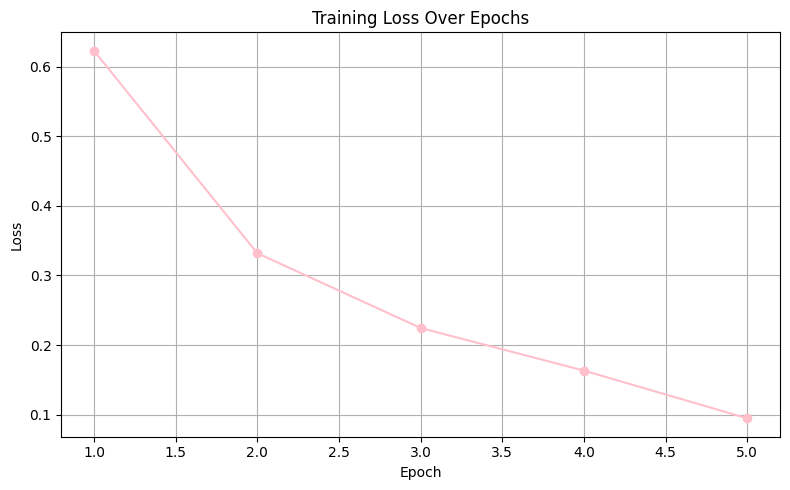

In [16]:
import matplotlib.pyplot as plt

num_epochs = 5
train_losses = []

for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    train_losses.append(train_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {train_loss:.4f}")

# Plot the training loss
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', linestyle='-', color='pink')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

In [17]:
from sklearn.metrics import classification_report

all_preds = []
all_labels = []

idx2label = {v: k for k,v in label2idx.items()}

pad_label_id = label2idx["0"]

model.eval()
with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        predictions = torch.argmax(outputs, dim=-1)

        for i in range(labels.size(0)):
            for j in range(labels.size(1)):
                if labels[i][j].item() != pad_label_id:
                    true_label = idx2label[labels[i][j].item()]
                    pred_label = idx2label[predictions[i][j].item()]
                    all_labels.append(true_label)
                    all_preds.append(pred_label)

print(classification_report(all_labels, all_preds, digits=4))

              precision    recall  f1-score   support

       NEG_1     0.9790    0.9885    0.9837      1132
      NSCO_1     0.9732    0.9905    0.9818      3592
       UNC_1     0.9268    0.7638    0.8375       199
     UNSCO_1     0.9278    0.8622    0.8938       566

    accuracy                         0.9687      5489
   macro avg     0.9517    0.9013    0.9242      5489
weighted avg     0.9680    0.9687    0.9679      5489

